시계열 분석 20210618
--

통계적 기법 분야 연구 리뷰

https://www.jksqm.org/m/journal/view.php?number=765

In [ ]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
# tsa - 시계열 중에 (trend, seasonal, residual(STL, Decomposition))
import statsmodels.formula.api as smg

## error analysis
# adf: 정상성을 알아보기 위한
# adf의 KPSS test -> 데이터의 안정성

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        stationary_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                 index=['Test statistics','p-value','Used lag','Used Obervations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            stationary_adf['Critical value(%s)' %key]=value
            stationary_adf['Maximum Information Criteria']=sm.tsa.stattools.adfuller(Y_Data)[5]
            stationary_adf=pd.DataFrame(stationary_adf, colums=['Stationarity_adf'])
        
    else:
        stationary_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4], 
                                    index=['Test Statistics','p-value','Used lag','Used Observations'])
            
        for key,value in sm.tsa.stattools.adfuller(Target_name)[4].items():
                stationary_adf['Critical value(%s)'%key]=value
                stationary_adf['Maximum Information Criteria']=sm.tsa.stattools.adfuller(Target_name)[5]
                stationary_adf=pd.DataFrame(stationary_adf, columns=['Stationarity_adf'])

        return stationary_adf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- ADF(augmented dicky fuller) 검정

자기 상관과 함께 사용할 수 있다. 정상성 알아보기 위한 검정

https://chukycheese.github.io/translation/statistics/augmented-dickey-fuller-test/

In [ ]:
!pip install yfinance

In [ ]:
# 시계열 안정성 테스트
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# 테슬라
df_tsla=yf.download('TSLA', start='2019-12-01', end='2020-11-30')

# LG화학
df_lg=yf.download('051910.KS', start='2018-12-01', end='2020-11-30')

# 리듐아메리카
df_lac=yf.download('LAC', start='2018-12-01', end='2020-11-30')

# 각 종목의 종가 데이터만 모아서 하나의 테이블을 합치기
df=pd.merge(df_tsla['Adj Close'], df_lg['Adj Close'],left_index=True, right_index=True, how='left').rename(columns={'Adj Close_x':'TSLA','Adj Close_y':'LG_chem'}) #LG Chem을 LG로 잘못 불러옴

df=pd.merge(df, df_lac['Adj Close'], left_index=True, right_index=True, how='left').rename(columns={'Adj Close':'LAC'})

df.dropna(inplace=True)
print(df.head)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method NDFrame.head of                   TSLA       LG_chem    LAC
Date                                       
2019-12-02   66.973999  303222.09375   2.87
2019-12-03   67.239998  303712.71875   2.88
2019-12-04   66.606003  290955.84375   2.91
2019-12-05   66.073997  288011.93750   2.94
2019-12-06   67.178001  288993.21875   2.98
...                ...           ...    ...
2020-11-20  489.609985  715105.68750  10.34
2020-11-23  521.849976  738810.81250  10.40
2020-11-24  555.380005  789184.31250  10.65
2020-11-25  574.000000  778319.43750  11.06
2020-11-27  585.760010  800049.12500  11.52

[239 rows x 3 columns]>


concat: 1행일 때 붙이는 것이 안 됨.

merge: 위,아래,양옆 다 붙이는 것이 됨. concat의 확장버전

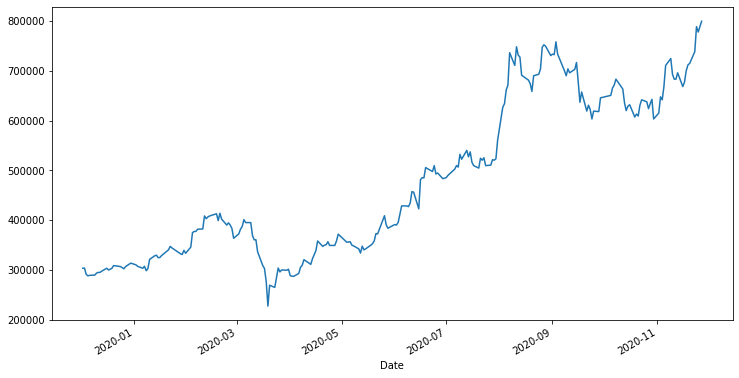

In [ ]:
# LG 화학 주가 데이터 시각화
import matplotlib.pyplot as plt

df['LG_chem'].plot(figsize=(12.2,6.4))

In [ ]:
# ADF 안정성 테스트
# ADF test: 시계열이 안정적(Stationary)인지 여부를 확인하는데 이용하는 것
# Null hypothesis: 기각에 실패하면 시계열이 안정적이지 않음을 의미
# Alternative hypothesis: 귀무 가설(null hypothesis)이 기각되고 시계열이 안정적이다.

n_obs=20
df_train, df_test=df[0:-n_obs], df[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result=adfuller(df.values)
    print('ADF Statistics: %f' %result[0])
    print('Critical values: ')
    for key, values in result[4].items():
        print('\t%s: %.3f'%(key, values))

print('ADF test: Tesla time series')
adf_test(df_train['TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df_train['LAC'])
print('ADF Test: LG chem time series')
adf_test(df_train['LG_chem'])

ADF test: Tesla time series
ADF Statistics: -0.426803
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Test: Lithium Americas time Series
ADF Statistics: -0.519722
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -0.839345
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [ ]:
# KPSSS: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 또는 단위 루트(unit root)로 인해 고정되지 않았는지?
# 이걸 확인하는 것.

# Null hypothesis: 시계열이 안정적이지 않음
# Alternative hypothesis: 시계열이 안정적

from statsmodels.tsa.stattools import kpss 

def kpss_test(df):
    statistics, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS statistics: {statistics}')
    print(f'p-values: {p_value}')
    print(f'num lags: {n_lags}')
    for key, value in critical_values.items():
        print(f' {key}:{value}')
print('KPSS test: Tesla time seriesa')
kpss_test(df_train['TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df_train['LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df_train['LG_chem'])

KPSS test: Tesla time seriesa
KPSS statistics: 1.311781938254864
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 1.0334501601687882
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 1.2294773851252327
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


In [ ]:
#ADF 하고 KPSS 시계열을 모두 사용하였는데 안정하지 않다는 것을 암.
# 차분(또는 비율로) 시계열을 변환시켜 안정적으로 만들어야함.

# 일일 수익률(=변화율)로 변환하기 -> 두 개의 연속된 시계열 값의 차분(diffence)을 취하는 방법 -> 가장 많이 쓰는 방법
# 주식 데이터에서는 차분 값보다는 수익률이 더욱 이해하기가 쉽기 때문에 일일변화율을 계산하여 시계열 데이터를 적용.

# 일일 주가 변화율 계산
for col in df.columns:
    df['r_'+col]=100*df[col].pct_change()
    #pct_change(percent change)
df.dropna(inplace=True)
print(df.head())

                 TSLA       LG_chem   LAC    r_TSLA  r_LG_chem     r_LAC
Date                                                                    
2019-12-03  67.239998  303712.71875  2.88  0.397167   0.161804  0.348440
2019-12-04  66.606003  290955.84375  2.91 -0.942884  -4.200310  1.041666
2019-12-05  66.073997  288011.93750  2.94 -0.798735  -1.011805  1.030927
2019-12-06  67.178001  288993.21875  2.98  1.670860   0.340709  1.360543
2019-12-09  67.905998  289483.87500  3.03  1.083683   0.169781  1.677851


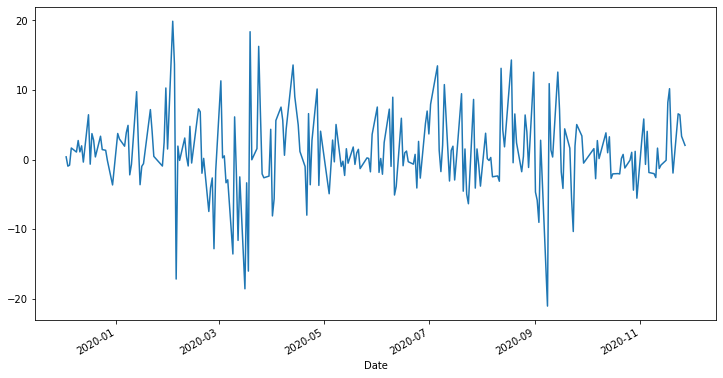

In [ ]:
plt.show(df['r_TSLA'].plot(figsize=(12.2,6.4)))

In [ ]:
# 차분해서 넣기
n_obs=20
df_train, df_test=df[0:-n_obs], df[-n_obs:]

print('ADF test: Tesla time series')
adf_test(df_train['TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df_train['LAC'])
print('ADF Test: LG chem time series')
adf_test(df_train['LG_chem'])

ADF test: Tesla time series
ADF Statistics: -0.427168
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: Lithium Americas time Series
ADF Statistics: -0.511177
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -0.861097
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [ ]:
print('KPSS test: Tesla time seriesa')
kpss_test(df_train['r_TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df_train['r_LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df_train['r_LG_chem'])

KPSS test: Tesla time seriesa
KPSS statistics: 0.06332825248962899
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 0.10728296903518375
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 0.08276186333234159
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


시계열 분석 20210625
--

시계열 안정성 테스트 - ADF(augmneated Cikey - Fuller)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install yfinance

In [57]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')


# 테슬라
df_tsla=yf.download('TSLA', start='2019-12-01', end='2020-11-30')

# LG화학
df_lg=yf.download('051910.KS', start='2019-12-01', end='2020-11-30')

#리튬아메리카
df_lac=yf.download('LAC', start='2019-12-01', end='2020-11-30')

# GameStop
df_game=yf.download('GME', start='2020-12-01', end='2021-05-31')

#각 종목의 증가 데이터만 모아서 하나의 테이블을 합치기
df=pd.merge(df_tsla['Adj Close'], df_lg['Adj Close'], left_index=True, right_index=True, how='left').rename(columns={'Adj Close_x': 'TSLA', 'Adj Close_y':'LG_chem'})

df=pd.merge(df, df_lac['Adj Close'], left_index=True, right_index=True, how='left').rename(columns={'Adj Close':'LAC'})

df.dropna(inplace=True)
print(df.head)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method NDFrame.head of                   TSLA       LG_chem    LAC
Date                                       
2019-12-02   66.973999  303222.09375   2.87
2019-12-03   67.239998  303712.71875   2.88
2019-12-04   66.606003  290955.84375   2.91
2019-12-05   66.073997  288011.93750   2.94
2019-12-06   67.178001  288993.21875   2.98
...                ...           ...    ...
2020-11-20  489.609985  715105.68750  10.34
2020-11-23  521.849976  738810.81250  10.40
2020-11-24  555.380005  789184.31250  10.65
2020-11-25  574.000000  778319.43750  11.06
2020-11-27  585.760010  800049.12500  11.52

[239 rows x 3 columns]>


In [58]:
df_game['GME']=df_game['Adj Close']

In [59]:
gme=df_game['GME']

In [60]:
df_game=pd.DataFrame(gme, index=df_game.index, columns=['GME'])

In [61]:
df.head()

,TSLA,LG_chem,LAC
Date,,,
2019-12-02,66.973999,303222.09375,2.87
2019-12-03,67.239998,303712.71875,2.88
2019-12-04,66.606003,290955.84375,2.91
2019-12-05,66.073997,288011.93750,2.94
2019-12-06,67.178001,288993.21875,2.98


In [62]:
df_game.head()

,GME
Date,
2020-12-01,15.800000
2020-12-02,16.580000
2020-12-03,16.120001
2020-12-04,16.900000
2020-12-07,16.350000


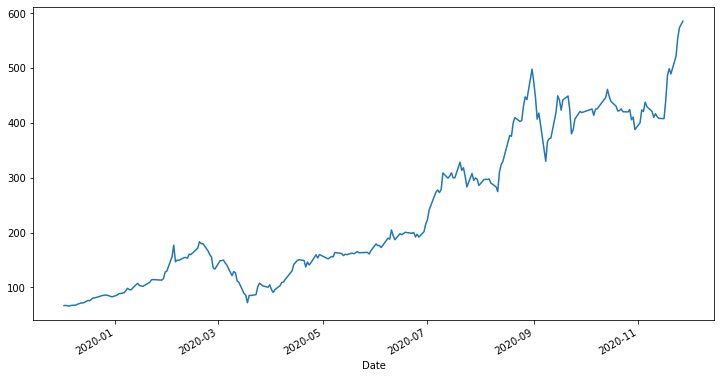

In [63]:
plt.show(df['TSLA'].plot(figsize=(12.2,6.4)))

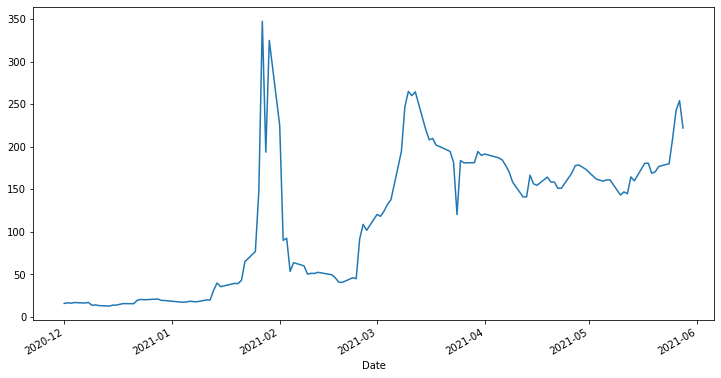

In [64]:
plt.show(df_game['GME'].plot(figsize=(12.2,6.4)))

# ADF test: 시계열이 안정적(stationary)인지 여부를 확인하는데 이용하는 것

Null hypothesis(귀무가설): 기각에 실패하면 시계열이 안정적이 않음을 의미

Alternative hypothesis(대립가설): 귀무 가설이 기각되고 시계열이 안정적임을 의미

In [67]:
# ADF 안정성 테스트
# ADF test: 시계열이 안정적(Stationary)인지 여부를 확인하는데 이용하는 것
# Null hypothesis: 기각에 실패하면 시계열이 안정적이지 않음을 의미
# Alternative hypothesis: 귀무 가설(null hypothesis)이 기각되고 시계열이 안정적이다.

n_obs=20
df_train, df_test=df[0:-n_obs], df[-n_obs:]
df_game_train, df_game_test=df_game[0:-n_obs], df_game[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result=adfuller(df.values)
    print('ADF Statistics: %f' %result[0])
    print('Critical values: ')
    for key, values in result[4].items():
        print('\t%s: %.3f'%(key, values))

print('ADF test: Tesla time series')
adf_test(df_train['TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df_train['LAC'])
print('ADF Test: LG chem time series')
adf_test(df_train['LG_chem'])


print('ADF Test: GME time series')
adf_test(df_game_train['GME'])

ADF test: Tesla time series
ADF Statistics: -0.426803
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Test: Lithium Americas time Series
ADF Statistics: -0.519722
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -0.839345
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Test: GME time series
ADF Statistics: -1.686394
Critical values: 
	1%: -3.499
	5%: -2.892
	10%: -2.583


P-value > 0.05이므로 귀무 가설을 기각할 수 없음. 세 개의 시계열은 안정적이지 않다.

KPSS: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지? 또는 단위 루트(unit root)로 인해 고정되지 않았는지? 를 확인하는 것 
--

Null hypothesis: 시계열이 안정적

Alternative hypothesis: 시계열이 안정적이지 않다.

In [68]:
# KPSSS: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 또는 단위 루트(unit root)로 인해 고정되지 않았는지?
# 이걸 확인하는 것.

# Null hypothesis: 시계열이 안정적이지 않음
# Alternative hypothesis: 시계열이 안정적

from statsmodels.tsa.stattools import kpss 

def kpss_test(df):
    statistics, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS statistics: {statistics}')
    print(f'p-values: {p_value}')
    print(f'num lags: {n_lags}')
    for key, value in critical_values.items():
        print(f' {key}:{value}')
print('KPSS test: Tesla time seriesa')
kpss_test(df_train['TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df_train['LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df_train['LG_chem'])
print('KPSS Test: GME time series')
kpss_test(df_game_train['GME'])

KPSS test: Tesla time seriesa
KPSS statistics: 1.311781938254864
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 1.0334501601687882
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 1.2294773851252327
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: GME time series
KPSS statistics: 0.6561268823805283
p-values: 0.017533919783588335
num lags: 13
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


p-value < 0.05 이므로 귀무 가설을 기각하며, 세 개의 시계열은 안정적이지 않음을 알 수 있다.

ADF하고 KPSS 시계열을 모두 사용을 하였는데 안정하지 않다는 것을 암.

차분 (또는 비율로) 시계열 열을 변환시켜야함 -> 안정적으로 만들어야 함.

일일 수익률(=변화율)로 변환하기 -> 두 개의 연속된 시계열 값의 차분(diffence)를 취하는 방법 -> 가장 많이 쓰이는 방법

주식 데이터는 차분값보다는 수익률로 더욱 이해하기 쉽기 때문에 일일변화율을 계산하여 시계열 데이터를 적용.

In [70]:
# 일일 주가 변화율 계산.

for col in df.columns:
    df['r_'+col]=100*df[col].pct_change()
    #pct_change: percentage change
df.dropna(inplace=True)
df.head()

,TSLA,LG_chem,LAC,r_TSLA,r_LG_chem,r_LAC,r_r_TSLA,r_r_LG_chem,r_r_LAC
Date,,,,,,,,,
2019-12-09,67.905998,289483.87500,3.03,1.083683,0.169781,1.677851,-35.142175,-50.168189,23.322149
2019-12-10,69.767998,293409.06250,3.14,2.742025,1.355926,3.630367,153.028254,698.631336,116.370109
2019-12-11,70.540001,294881.03125,3.23,1.106529,0.501678,2.866239,-59.645553,-63.001081,-21.048235
2019-12-12,71.935997,294881.03125,3.13,1.979013,0.000000,-3.095972,78.848753,-100.000000,-208.015139
2019-12-13,71.678001,297334.28125,3.07,-0.358646,0.831946,-1.916939,-118.122466,inf,-38.082823


In [71]:
for col in df_game.columns:
    df_game['r_'+col]=100*df_game[col].pct_change()
    #pct_change: percentage change
df_game.dropna(inplace=True)
df_game.head()

,GME,r_GME
Date,,
2020-12-02,16.580000,4.936707
2020-12-03,16.120001,-2.774422
2020-12-04,16.900000,4.838702
2020-12-07,16.350000,-3.254433
2020-12-08,16.940001,3.608564


일일 수익률(=주가 변화율) 시각화 하기

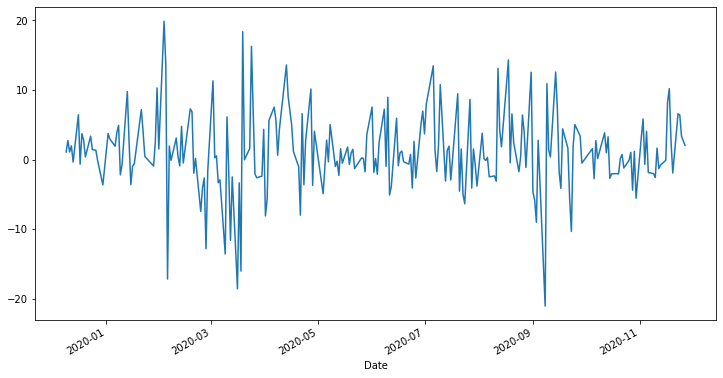

In [73]:
plt.show(df['r_TSLA'].plot(figsize=(12.2,6.4)))

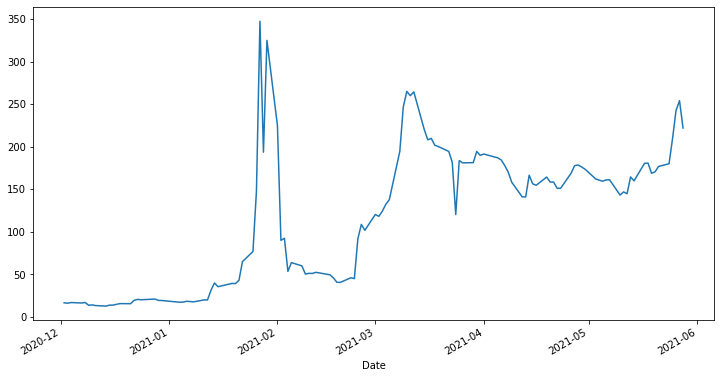

In [75]:
plt.show(df_game['GME'].plot(figsize=(12.2,6.4)))

In [76]:
print('ADF test: Tesla time series')
adf_test(df['r_TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df['r_LAC'])
print('ADF Test: LG chem time series')
adf_test(df['r_LG_chem'])


print('ADF Test: GME time series')
adf_test(df_game['r_GME'])

ADF test: Tesla time series
ADF Statistics: -14.885087
Critical values: 
	1%: -3.459
	5%: -2.874
	10%: -2.573
ADF Test: Lithium Americas time Series
ADF Statistics: -8.207718
Critical values: 
	1%: -3.459
	5%: -2.874
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -7.410366
Critical values: 
	1%: -3.459
	5%: -2.874
	10%: -2.573
ADF Test: GME time series
ADF Statistics: -5.876200
Critical values: 
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [77]:
print('KPSS test: Tesla time seriesa')
kpss_test(df['r_TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df['r_LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df['r_LG_chem'])
print('KPSS Test: GME time series')
kpss_test(df_game['r_GME'])

KPSS test: Tesla time seriesa
KPSS statistics: 0.0461078419884074
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 0.09914133294812841
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 0.06847083906417828
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: GME time series
KPSS statistics: 0.14474191835191674
p-values: 0.1
num lags: 13
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


Error Analysis
--

In [98]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4], 
                                   index=['Test Statistics','p-value','Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data)[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                       index=['Test Statistics','p-value','Used Lag','Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationary_kpss_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3], 
                                   index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                       index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss
                                

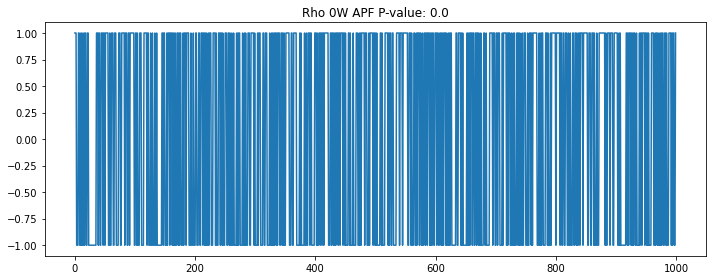

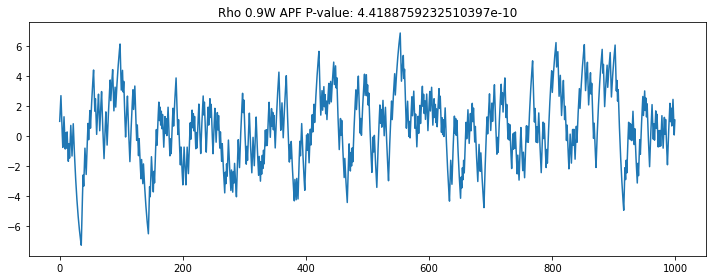

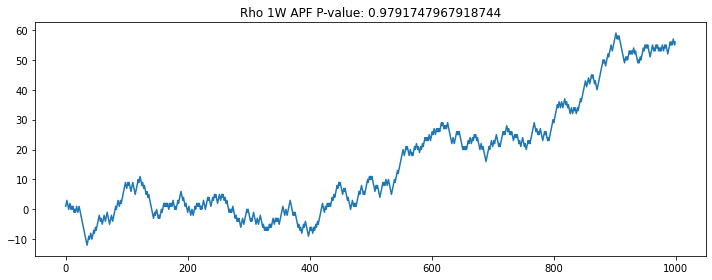

In [100]:
from random import seed, random
import matplotlib.pyplot as plt
import numpy as np


# 랜덤워크 데이터 생성 및 통계량 Test (rho=0)
plt.figure(figsize=(10,4))
seed(1)
rho=0 
random_walk=[-1 if random()>0.5 else 1]

for i in range(1, 1000):
    movement=-1 if random()<0.5 else 1 #list가 아닌 value값으로 붙히고 싶어서
    value= rho*random_walk[i-1]+movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho {}W APF P-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=0.9)
plt.figure(figsize=(10,4))
seed(1)
rho=0.9
random_walk=[-1 if random()>0.5 else 1]

for i in range(1, 1000):
    movement=-1 if random()<0.5 else 1 #list가 아닌 value값으로 붙히고 싶어서
    value= rho*random_walk[i-1]+movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho {}W APF P-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=1)
plt.figure(figsize=(10,4))
seed(1)
rho=1
random_walk=[-1 if random()>0.5 else 1]

for i in range(1, 1000):
    movement=-1 if random()<0.5 else 1 #list가 아닌 value값으로 붙히고 싶어서
    value= rho*random_walk[i-1]+movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho {}W APF P-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

- 계수가 1(rho=1)에 가까울수록 원래 차트와 유사해짐

시계열 알고리즘
---

# 비대칭(Skewed) 데이터를 처리하는 방법

House Prices 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [ ]:
from google.colab import files 
files.upload()

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_sub=pd.read_csv('sample_submission.csv')

In [104]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [105]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [106]:
df_sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


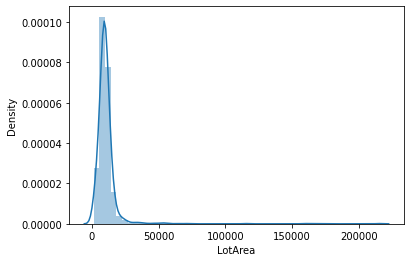

In [108]:
#skewness 확인
df_train['LotArea'].skew()

# KDE plot 확인
sns.distplot(df_train['LotArea']) #displot 찍으면 선 사라짐

## log Transform

- Skewness를 제거하기 위해 가장 간단한 방법

In [109]:
# 값들을 확인
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


-0.1379938086958118


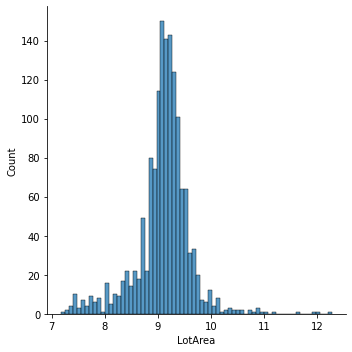

In [110]:
#로그 변환
df_log=np.log(df_train['LotArea'])

#skewness 확인
print(df_log.skew())

# KDE plot 출력
sns.displot(df_log)

## Square Root Transform / 루트(제곱근) 변환

- 루트 변환

In [111]:
#루트 변환
df_root=np.sqrt(df_train['LotArea'])/len(df_train['LotArea'])

4.139713548289235


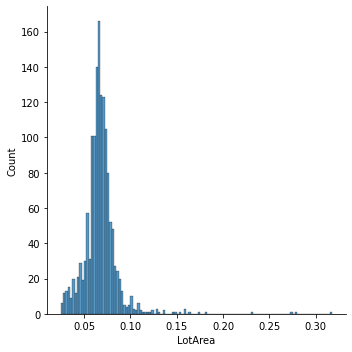

In [112]:
#skewness 확인
print(df_root.skew())
#KDE plot 출력
sns.displot(df_root)

## Box-cox transform

- 변환 목적

1) 정규분포가 아닌 자료를 정규분포로 변환하기 위해서 사용

2) 연속형 측정자료의 형태를 파악

3) 추후 통계분석에 대한 정규분포 가정을 검정.

0.026686965055625272


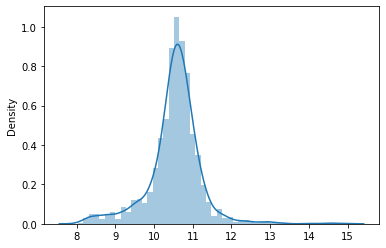

In [116]:
from scipy.stats import boxcox

# box-cos 변환
df_boxcos=pd.Series(boxcox(df_train['LotArea'])[0])

#skewness 확인
print(df_boxcos.skew())

# KDE plot 출력
sns.distplot(df_boxcos)

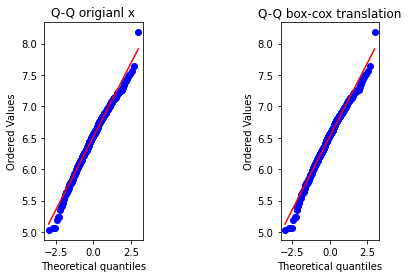

최적의 람다값 2.399178840216162


In [117]:
from scipy import stats
import matplotlib.pyplot as plt

#그림판 준비
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(133)

#log gamma continuous random variable 생성
x = stats.loggamma.rvs(5,size = 500) +5
# Q-Q plot 그리긔
prob = stats.probplot(x, dist = stats.norm, plot = ax1)
ax1.set_title('Q-Q origianl x')

# box-cox 변환 사용
x_trans, optimal_labmda = stats.boxcox(x)
prob = stats.probplot(x, dist = stats.norm, plot = ax2)
ax2.set_title('Q-Q box-cox translation')
plt.show()

# box-cox 최적의 람다값 찾기
print('최적의 람다값', optimal_labmda)

### 정상성 테스트 방향

> **추세와 계절성 모두 제거된 정상성 데이터 변환 필요!**
>> - **ADF 정상성 확인 -> 추세 제거 확인 Measure**  
: ADF 검정통계량은 정상이라고 해도 데이터에 계절성이 포함되면 ACF의 비정상 Lag 존재하는 비정상데이터 가능  

>> - **KPSS 정상성 확인 -> 계절성 제거 확인 Measure**  
: KPSS 검정통계량은 정상이라고 해도 데이터에 추세가 포함되면 ACF의 비정상 Lag 존재하는 비정상데이터 가능 

In [118]:
# error analysis

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4], 
                                   index=['Test Statistics','p-value','Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data)[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                       index=['Test Statistics','p-value','Used Lag','Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationary_kpss_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3], 
                                   index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                       index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

In [120]:
# 라이브러리 및 데이터 로딩
import pandas as pd
from statsmodels import datasets
import matplotlib.pyplot as plt
import statsmodels.api as sm

raw_set =datasets.get_rdataset('deaths', package='MASS')
raw=raw_set.data
raw

,time,value
0,1974.000000,3035
1,1974.083333,2552
2,1974.166667,2704
3,1974.250000,2554
4,1974.333333,2014
...,...,...
67,1979.583333,1354
68,1979.666667,1333
69,1979.750000,1492
70,1979.833333,1781


In [123]:
raw_set.keys()

dict_keys(['data', '__doc__', 'package', 'title', 'from_cache', 'raw_data'])

In [124]:
# 시간변수 추출

raw.time=pd.date_range('1974-01-01', periods=len(raw), freq='M')
raw['month']=raw.time.dt.month
raw

,time,value,month
0,1974-01-31,3035,1
1,1974-02-28,2552,2
2,1974-03-31,2704,3
3,1974-04-30,2554,4
4,1974-05-31,2014,5
...,...,...,...
67,1979-08-31,1354,8
68,1979-09-30,1333,9
69,1979-10-31,1492,10
70,1979-11-30,1781,11


In [125]:
#데이터 확인 및 추세 추정
display(raw.tail())

,time,value,month
67,1979-08-31,1354,8
68,1979-09-30,1333,9
69,1979-10-31,1492,10
70,1979-11-30,1781,11
71,1979-12-31,1915,12


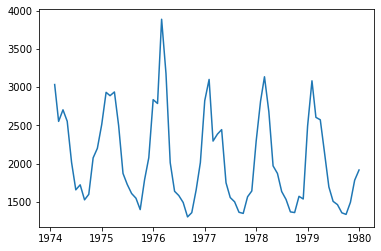

In [126]:
# 데이터 확인 및 추세 추정
# display(raw.tail())
plt.plot(raw.time, raw.value)
plt.show()

,Stationarity_adf
Test Statistics,-0.568650
p-value,0.877910
Used Lag,12.000000
Used Observations,59.000000
Critical Value(1%),-3.546395
Maximum information Criteria,841.377559


,Stationarity_kpss
Test Statistics,0.651989
p-value,0.017910
Used Lag,12.000000
Critical Value(10%),0.347000


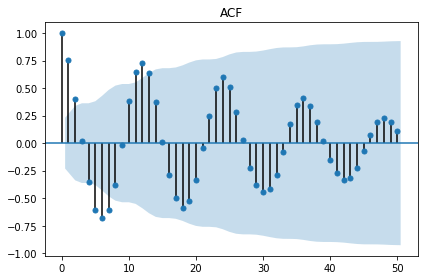

In [131]:
display(stationary_adf_test(raw.value, []))
display(stationary_kpss_test(raw.value, []))
sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True, title='ACF')
plt.tight_layout()
plt.show()

In [151]:
# c(month): 더미화 작업 / -1 절편을 제거
# constant_x를 따로 취해주지 않았기 때문에 여기서 C(month)에서 하나를 빼줌으로써
# y=b0+b1x1+b2x2에서 b0을 뛰고 x1부터 시작할 수 있게 해준다.
result=sm.OLS.from_formula(formula='value ~ C(month)-1',data=raw).fit()
display(result.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     31.66
Date:                Fri, 25 Jun 2021   Prob (F-statistic):           6.55e-21
Time:                        06:34:33   Log-Likelihood:                -494.38
No. Observations:                  72   AIC:                             1013.
Df Residuals:                      60   BIC:                             1040.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[1]   2959.3333    103.831     28.502      0.000    2751.641    3167.025
C(month)[2]   2894.6667    103.831     27.879      0.000    2686.975    3102.359
C(month)[3]   2743.0000    103.831     26.418      0.000    2535.308    2950.692
C(month)[4]   2269.6667    103.831     21.859      0.000    2061.975    2477.359
C(month)[5]   1805.1667    103.831     17.386      0.000    1597.475    2012.859
C(month)[6]   1608.6667    103.831     15.493      0.000    1400.975    1816.359
C(month)[7]   1550.8333    103.831     14.936      0.000    1343.141    1758.525
C(month)[8]   1408.3333    103.831     13.564      0.000    1200.641    1616.025
C(month)[9]   1397.3333    103.831     13.458      0.000    1189.641    1605.025
C(month)[10]  1690.0000    103.831     16.277      0.000    1482.308    1897.692
C(month)[11]  1874.0000    103.831     18.049      0.000    1666.308    2081.692
C(month)[12]  2478.5000    103.831     23.871      0.000    2270.808    2686.192
==============================================================================
Omnibus:                       19.630   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.630
Skew:                           0.787   Prob(JB):                     1.67e-11
Kurtosis:                       6.750   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

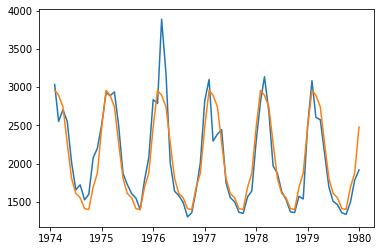

In [154]:
# fittedvalues: 판별함수 z=w^T X: 실제 fitting값.

plt.plot(raw.time, raw.value, raw.time, result.fittedvalues)
plt.show()

,Stationarity_adf
Test Statistics,-5.842931e+00
p-value,3.740637e-07
Used Lag,0.000000e+00
Used Observations,7.100000e+01
Critical Value(1%),-3.526005e+00
Maximum information Criteria,8.123641e+02


,Stationarity_kpss
Test Statistics,0.538249
p-value,0.033052
Used Lag,12.000000
Critical Value(10%),0.347000


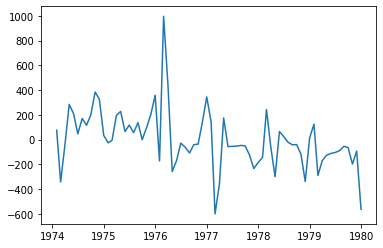

In [157]:
# 추세 제거 및 정상성 확인
# resid: 잔차
plt.plot(raw.time, result.resid)

display(stationary_adf_test(result.resid, []))
display(stationary_kpss_test(result.resid, []))

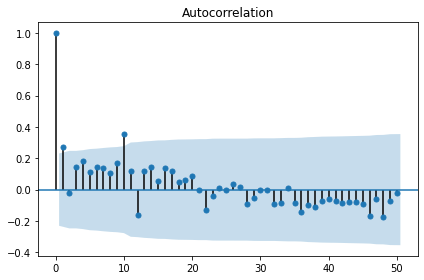

In [160]:
sm.graphics.tsa.plot_acf(result.resid, lags=50, use_vlines=True)
plt.tight_layout()
plt.show()

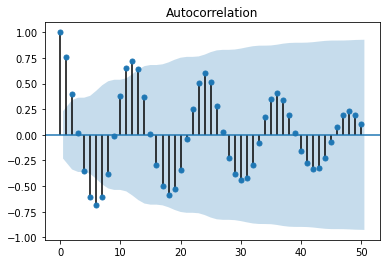

In [161]:
# 계절성 제거 및 정상성 확인
# 방법2

sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True)
plt.show()

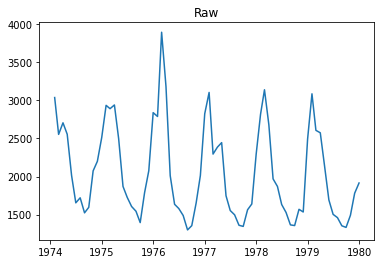

In [162]:
plt.plot(raw.time, raw.value)
plt.title('Raw')
plt.show()

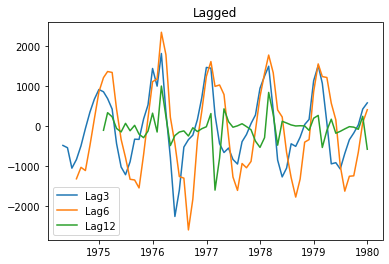

In [165]:
seasonal_lag = 3
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
seasonal_lag = 6
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
seasonal_lag = 12
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
plt.title('Lagged')
plt.legend()
plt.show()

,Stationarity_adf
Test Statistics,-5.572673
p-value,0.000001
Used Lag,10.000000
Used Observations,58.000000
Critical Value(1%),-3.548494
Maximum information Criteria,826.272024


,Stationarity_kpss
Test Statistics,0.362944
p-value,0.093128
Used Lag,11.000000
Critical Value(10%),0.347000


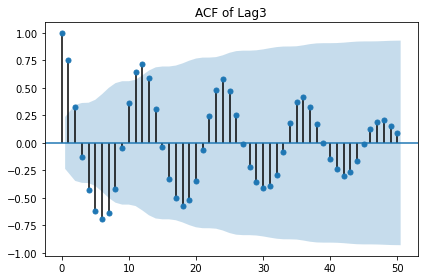

In [169]:
seasonal_lag = 3
display(stationary_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationary_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

,Stationarity_adf
Test Statistics,-4.299976
p-value,0.000444
Used Lag,11.000000
Used Observations,54.000000
Critical Value(1%),-3.557709
Maximum information Criteria,786.671043


,Stationarity_kpss
Test Statistics,0.349646
p-value,0.098859
Used Lag,11.000000
Critical Value(10%),0.347000


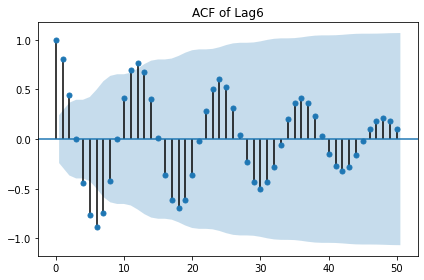

In [167]:
# seasonal_lag는 6이 딱 좋다!

seasonal_lag = 6
display(stationary_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationary_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

,Stationarity_adf
Test Statistics,-2.137208
p-value,0.229819
Used Lag,11.000000
Used Observations,48.000000
Critical Value(1%),-3.574589
Maximum information Criteria,703.717969


,Stationarity_kpss
Test Statistics,0.09452
p-value,0.10000
Used Lag,11.00000
Critical Value(10%),0.34700


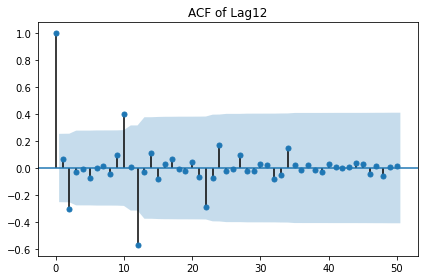

In [168]:
seasonal_lag = 12
display(stationary_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationary_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

20210628 수업
--